# Imports

In [ ]:
!pip install sacrebleu
!pip install evaluate
!pip install rouge_score

import math
import evaluate
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import tiktoken
from transformers import GPT2Tokenizer
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset, load_metric, DatasetDict
from torchsummaryX import summary
import wandb
from dataclasses import dataclass
from tqdm import tqdm
import re
from multiprocessing import cpu_count
import random
import gc
import pickle

from nltk.translate.bleu_score import sentence_bleu

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=15d43096f725231144c6ce91fbb69d4a030c4d11ca78052a6b18cddaf6d1f503
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
# set seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
cudnn.deterministic = True
cudnn.benchmark = False
random.seed(42)

# Load Data

In [ ]:
datasets_train = load_dataset("Shannnh/hw5-changed", split = 'train')
datasets_val = load_dataset("Shannnh/hw5-changed", split = 'validation')
datasets_test = load_dataset("Shannnh/hw5-changed", split = 'test_ds')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
print(datasets_train[0].keys())
print(len(datasets_train))
print(len(datasets_val))
print(len(datasets_test))

dict_keys(['Classifier', 'Prompt', 'Messages', 'PromptId'])
392632
27664
15434


In [ ]:
# datasets_train = datasets_train.shuffle(seed=42).select(range(100))
# datasets_val = datasets_val.shuffle(seed=42).select(range(10))

In [ ]:
datasets_train.unique('Classifier')

['Summarization', 'Question&Answer', 'SentimentAnalysis', 'NamedEntity']

# Hyperparameters

In [ ]:
@dataclass
class IDeaLGPTConfig:

    # General
    batch_size: int = 8
    gradient_accumulation_steps: int = 4
    num_iters: int = 5
    eval_iters: int = 3
    eval_interval: int = 1
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    # device: str = 'cpu'

    # Model
    sequence_length: int = 256
    vocab_size: int = 50257 # gpt2 vocab
    num_blocks: int = 8
    num_heads: int = 8
    embed_dim: int = 512
    dropout: float = 0.1
    bias: bool = False

    # Data
    num_workers: int = 8
    train_test_split: float = 0.8
    SUBSET_PERCENTAGE: float =0.01 # % of OWT to train on, between 0 and 1

    # LR scheduler
    lr: float = 2e-3
    lr_decay: bool = True
    warmup_iters: int = 1000
    min_lr: float = 6e-6

    # optimizer
    weight_decay: float = 1e-1
    grad_clip: float = 1.0


config = IDeaLGPTConfig()
device = config.device
config

IDeaLGPTConfig(batch_size=8, gradient_accumulation_steps=4, num_iters=5, eval_iters=3, eval_interval=1, device='cuda', sequence_length=256, vocab_size=50257, num_blocks=8, num_heads=8, embed_dim=512, dropout=0.1, bias=False, num_workers=8, train_test_split=0.8, SUBSET_PERCENTAGE=0.01, lr=0.002, lr_decay=True, warmup_iters=1000, min_lr=6e-06, weight_decay=0.1, grad_clip=1.0)

In [ ]:
print(f'Effective batch size = {config.batch_size * config.gradient_accumulation_steps}')

Effective batch size = 32


# Loading Data and Preprocessing

In [ ]:
# hf_dataset = load_dataset("Skylion007/openwebtext", split='train') # only has one split - train
# hf_dataset = hf_dataset.with_format("torch")
# hf_dataset

In [ ]:
# # data = dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * SUBSET_PERCENTAGE)))
# # hf_dataset = hf_dataset.select(range(int(len(hf_dataset) * config.SUBSET_PERCENTAGE)))
# hf_dataset = hf_dataset.train_test_split(train_size=config.train_test_split)
# hf_dataset

In [ ]:
# train_hf_dataset, val_hf_dataset = hf_dataset['train'], hf_dataset['test']

## Tokenizer - OpenAI tiktoken (changed to GPT2Tokenizer)

In [ ]:
#tokenizer = tiktoken.get_encoding("cl100k_base") # gpt4 tokenizer - NOTE: need to change vocab_size in config if used
#tokenizer = tiktoken.encoding_for_model('gpt-2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.encode('hello world')


[31373, 995]

In [ ]:
tokenizer.model_max_length = config.sequence_length

In [ ]:
tokenizer.pad_token_id

In [ ]:
vocab_size = tokenizer.vocab_size #same as tiktoken
vocab_size

50257

In [ ]:
# set pad_token_id equal to the eos_token_id if not set
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

In [ ]:
DEFAULT_CHAT_TEMPLATE = "{% for message in messages %}\n{% if message['role'] == 'user' %}\n{{ '<|user|>\n' + ' '.join(message['content'].split()[:150]) + eos_token }}\n{% elif message['role'] == 'system' %}\n{{ '<|system|>\n' + message['content'] + eos_token }}\n{% elif message['role'] == 'assistant' %}\n{{ '<|assistant|>\n'  + message['content'] + eos_token }}\n{% endif %}\n{% if loop.last and add_generation_prompt %}\n{{ '<|assistant|>' }}\n{% endif %}\n{% endfor %}"
tokenizer.chat_template = DEFAULT_CHAT_TEMPLATE

In [ ]:
def apply_chat_template(example, tokenizer):
    messages = example["Messages"]
    #
    example["text"] = tokenizer.apply_chat_template(messages, tokenize=False, max_length=config.sequence_length, truncation=True)
    example["tokens"] = tokenizer.apply_chat_template(messages, tokenize=True, max_length=config.sequence_length, truncation=True)
    return example

column_names = list(datasets_train.features)
datasets_train = datasets_train.map(apply_chat_template,
                                num_proc=cpu_count(),
                                fn_kwargs={"tokenizer": tokenizer},
                                remove_columns=column_names,
                                desc="Applying chat template")
datasets_val = datasets_val.map(apply_chat_template,
                                num_proc=cpu_count(),
                                fn_kwargs={"tokenizer": tokenizer},
                                remove_columns=column_names,
                                desc="Applying chat template")
datasets_test = datasets_test.map(apply_chat_template,
                                num_proc=cpu_count(),
                                fn_kwargs={"tokenizer": tokenizer},
                                remove_columns=column_names,
                                desc="Applying chat template")


In [ ]:
# what's in datasets now
# datasets_train : [{'text':'abcd','tokens':[1,2,3]},{'text':'bcd','tokens':[2,3]},...]
for index in random.sample(range(len(datasets_val)), 2):
    print(f"Sample {index} of the processed training set:\n\n{datasets_val[index]['text']}")
    print(f"token: {datasets_val[index]['tokens']}")
    print(f"sample length: {len(datasets_val[index]['text'])}")
    print(f"token length:{len(datasets_val[index]['tokens'])}")

Sample 20952 of the processed training set:

<|system|>
<|endoftext|>
<|user|>
Economic_inequality While acknowledging the central role economic growth can potentially play in human development, poverty reduction and the achievement of the Millennium Development Goals, it is becoming widely understood amongst the development community that special efforts must be made to ensure poorer sections of society are able to participate in economic growth. The effect of economic growth on poverty reduction – the growth elasticity of poverty – can depend on the existing level of inequality. For instance, with low inequality a country with a growth rate of 2% per head and 40% of its population living in poverty, can halve poverty in ten years, but a country with high inequality would take nearly 60 years to achieve the same reduction. In the words of the Secretary General of the United Nations Ban Ki-Moon: "While economic growth is necessary, it is not sufficient for progress on reducing poverty.

In [ ]:
# total_token_length = 0
# sample_count = len(datasets_train)

# # Calculate total token length across all samples
# for data in tqdm(datasets_train):
#     encoded_length = len(tokenizer.encode(data['text']))
#     total_token_length += encoded_length

# # Compute the average token length
# average_token_length = total_token_length / sample_count

# print(f"Average token length: {average_token_length}")

In [ ]:
torch.cuda.empty_cache()
gc.collect()

48

In [ ]:
# save dataset

def save_dataset(dataset, filename):
    with open(filename, 'wb') as f:
        pickle.dump(dataset, f)
save_dataset(datasets_train, 'hw5/train.bin')
save_dataset(datasets_val, 'hw5/val.bin')
save_dataset(datasets_test, 'hw5/test.bin')

## Pytorch Dataset

For long texts, the current approach randomly selects segments of text that are equal to config.sequence_length. However, methods such as sliding windows could also be explored.

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, root_dir, split):
        """
        Args:
            root_dir (str): Dataset root directory containing the data files.
        """
        file_path = os.path.join(root_dir, "train.bin") if split == 'train' else os.path.join(root_dir, "val.bin")
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        tokens = sample['tokens']
        # if the number of tokens is more than the sequence_length, randomly choose a segment
        # if len(tokens) > config.sequence_length + 1:
        #     num_possible_starts = len(tokens) - config.sequence_length
        #     start = random.randint(0, num_possible_starts - 1)
        #     segment = tokens[start:start + self.sequence_length + 1]
        # else:
        #     segment = tokens

        if len(tokens) < config.sequence_length + 1:
            padded_tokens = np.pad(tokens, (0, config.sequence_length + 1 - len(tokens)), 'constant', constant_values=tokenizer.pad_token_id)
        else:
            padded_tokens = tokens[:config.sequence_length + 1]

        xb = torch.tensor(padded_tokens[:-1], dtype=torch.int64)
        yb = torch.tensor(padded_tokens[1:], dtype=torch.int64)
        return xb, yb


In [ ]:
# class TestDataset(Dataset):
#     def __init__(self, root_dir):
#         """
#         Args:
#             root_dir (str): Dataset root directory containing the data files.
#         """
#         file_path = os.path.join(root_dir, "test.bin")
#         with open(file_path, 'rb') as f:
#             data = pickle.load(f)
#         self.data = data

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         sample = self.data[idx]
#         tokens = sample['tokens']
#         # if len(tokens) > config.sequence_length + 1:
#         #     num_possible_starts = len(tokens) - config.sequence_length
#         #     start = random.randint(0, num_possible_starts - 1)
#         #     segment = tokens[start:start + config.sequence_length + 1]
#         # else:
#         #     segment = tokens
#         if len(tokens) < config.sequence_length + 1:
#             padded_tokens = np.pad(tokens, (0, config.sequence_length + 1 - len(tokens)), 'constant', constant_values=tokenizer.pad_token_id)
#         else:
#             padded_tokens = tokens[:config.sequence_length + 1]

#         xb = torch.tensor(padded_tokens[:-1], dtype=torch.int64)
#         return xb


## Dataloader

In [ ]:
# train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=1)
# val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)

In [ ]:
# for x, y in train_loader:
#     print(x.shape, y.shape)
#     break

In [ ]:
'''
# poor man's dataloader
# but actual motivation is - im too lazy to write and deal with pad tokens in above method to read data
# since there are documents which are less than sequence length and they mess up the batch
# this method is cleaner, i get to learn something new (np.memmap!) and it's fun!

data_dir = os.path.join('data', 'owt')

def get_batch(split):
    file_path = os.path.join(data_dir, 'val' if split == 'val.bin' else 'train.bin')
    # memmap allows to read huge .bin files without loading entire thing. magic?
    data = np.memmap(file_path, mode='r', dtype=np.uint16) # fp16?
    idx = torch.randint(len(data) - config.sequence_length, (config.batch_size, ))
    xb = torch.stack([torch.from_numpy(data[i:i+config.sequence_length].astype(np.int64)) for i in idx], dim=0)
    yb = torch.stack([torch.from_numpy(data[i+1:i+config.sequence_length+1].astype(np.int64)) for i in idx], dim=0)
    if device == 'cuda':
        # pin_memory is an optimization to reserve some space in cpu mem which is used for moving to gpu
        # reduces overhead -> increases perf
        # non_blocking = True is async data transfer
        xb, yb = xb.pin_memory().to(device, non_blocking=True), yb.pin_memory().to(device, non_blocking=True)
    return xb, yb
'''

"\n# poor man's dataloader\n# but actual motivation is - im too lazy to write and deal with pad tokens in above method to read data\n# since there are documents which are less than sequence length and they mess up the batch\n# this method is cleaner, i get to learn something new (np.memmap!) and it's fun!\n\ndata_dir = os.path.join('data', 'owt')\n\ndef get_batch(split):\n    file_path = os.path.join(data_dir, 'val' if split == 'val.bin' else 'train.bin')\n    # memmap allows to read huge .bin files without loading entire thing. magic?\n    data = np.memmap(file_path, mode='r', dtype=np.uint16) # fp16?\n    idx = torch.randint(len(data) - config.sequence_length, (config.batch_size, ))\n    xb = torch.stack([torch.from_numpy(data[i:i+config.sequence_length].astype(np.int64)) for i in idx], dim=0)\n    yb = torch.stack([torch.from_numpy(data[i+1:i+config.sequence_length+1].astype(np.int64)) for i in idx], dim=0)\n    if device == 'cuda':\n        # pin_memory is an optimization to reserv

In [ ]:

DATA_DIR        = 'hw5'

train_dataset   = TrainDataset(
    root_dir    = DATA_DIR,
    split   = "train"
)

val_dataset     = TrainDataset(
    root_dir    = DATA_DIR,
    split   = "val"
)

# test_dataset    = TestDataset(
#     root_dir    = DATA_DIR
# )
gc.collect()


0

In [ ]:
xb, yb = train_dataset[0]
xb.shape, yb.shape

(torch.Size([256]), torch.Size([256]))

In [ ]:
train_loader    = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = config.batch_size,
    shuffle     = True,
    num_workers = 2,
    pin_memory  = True
)

val_loader      = torch.utils.data.DataLoader(
    dataset     = val_dataset,
    batch_size  = config.batch_size,
    shuffle     = False,
    num_workers = 1,
    pin_memory  = True
)

# test_loader     = torch.utils.data.DataLoader(
#     dataset     = test_dataset,
#     batch_size  = config.batch_size,
#     shuffle     = False,
#     num_workers = 1,
#     pin_memory  = True
# )

print("Batch Size           : ", config.batch_size)
print("Train Batches        : ", train_loader.__len__())
print("Val Batches          : ", val_loader.__len__())
# print("Test Batches         : ", test_loader.__len__())


Batch Size           :  8
Train Batches        :  49079
Val Batches          :  3458


In [ ]:
''' Sanity Check '''

print("Checking the Shapes of the Data --\n")

for batch in train_loader:
    xb, yb = batch

    print(f"xb shape:\t\t{xb.shape}")
    print(f"yb shape:\t\t{yb.shape}\n")



    break

Checking the Shapes of the Data --

xb shape:		torch.Size([8, 256])
yb shape:		torch.Size([8, 256])



In [ ]:
# I tried it, but failed.QAQ. It seems that using np.memmap requires synchronously recording the length of each data entry, which makes padding inconvenient.
'''
data_dir = '/content/hw5/'
def get_batch(split):
    file_path = os.path.join(data_dir, 'val.bin' if split == 'val' else 'train.bin')


    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    xb = torch.empty((config.batch_size, config.sequence_length), dtype=torch.int64)
    yb = torch.empty((config.batch_size, config.sequence_length), dtype=torch.int64)

    for b in range(config.batch_size):
        tokens = data[b]['tokens']
        if len(tokens) < config.sequence_length:
            padded_tokens = np.pad(tokens, (0, config.sequence_length - len(tokens)), 'constant', constant_values=tokenizer.pad_token_id)
        else:
            padded_tokens = tokens[:config.sequence_length]


        xb[b] = torch.tensor(padded_tokens[:-1], dtype=torch.int64)
        yb[b] = torch.tensor(padded_tokens[1:], dtype=torch.int64)

    if device == 'cuda':
        xb, yb = xb.pin_memory().to(device, non_blocking=True), yb.pin_memory().to(device, non_blocking=True)

    return xb, yb
'''

"\ndata_dir = '/content/hw5/'\ndef get_batch(split):\n    file_path = os.path.join(data_dir, 'val.bin' if split == 'val' else 'train.bin')\n\n\n    with open(file_path, 'rb') as f:\n        data = pickle.load(f)\n\n    xb = torch.empty((config.batch_size, config.sequence_length), dtype=torch.int64)\n    yb = torch.empty((config.batch_size, config.sequence_length), dtype=torch.int64)\n\n    for b in range(config.batch_size):\n        tokens = data[b]['tokens']\n        if len(tokens) < config.sequence_length:\n            padded_tokens = np.pad(tokens, (0, config.sequence_length - len(tokens)), 'constant', constant_values=tokenizer.pad_token_id)\n        else:\n            padded_tokens = tokens[:config.sequence_length]\n\n\n        xb[b] = torch.tensor(padded_tokens[:-1], dtype=torch.int64)\n        yb[b] = torch.tensor(padded_tokens[1:], dtype=torch.int64)\n\n    if device == 'cuda':\n        xb, yb = xb.pin_memory().to(device, non_blocking=True), yb.pin_memory().to(device, non_blocki

# Model

In [ ]:
class Head(nn.Module):
    # def __init__(self, embed_dim, head_size, sequence_length, dropout):
    def __init__(self, config, interim_head_size):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.interim_head_size = interim_head_size # say embed_dim = 32 -> broken into say 4 heads, so this will be 8, to be concated back to 32
        self.key = nn.Linear(config.embed_dim, interim_head_size, bias=config.bias)
        self.query = nn.Linear(config.embed_dim, interim_head_size, bias=config.bias)
        self.value = nn.Linear(config.embed_dim, interim_head_size, bias=config.bias)
        self.register_buffer('tril', torch.tril(torch.ones((config.sequence_length, config.sequence_length))))

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (b,t,c) -> (b,t,h)
        q = self.query(x) # (b,t,c) -> (b,t,h)
        v = self.value(x) # (b,t,c) -> (b,t,h)
        wei = k @ q.transpose(-2, -1) * self.embed_dim**(-0.5) # (b,t,h) @ (b,h,t) -> (b,t,t)

        wei = wei.masked_fill((self.tril[:T, :T] == 0.), -torch.inf) # type: ignore
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        xbow = wei @ v # (b,t,t) @ (b,t,h) -> (b,t,h)
        return xbow

class MultiHeadAttention(nn.Module):
    # def __init__(self, num_heads, embed_dim, head_size, sequence_length, dropout):
    def __init__(self, config, interim_head_size):
        super().__init__()
        self.head_list = nn.ModuleList([Head(config, interim_head_size) for _ in range(config.num_heads)])
        self.proj = nn.Linear(config.embed_dim, config.embed_dim)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.head_list], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(config.embed_dim, 4*config.embed_dim),
            nn.GELU(),
            nn.Linear(4*config.embed_dim, config.embed_dim),
            nn.Dropout(config.dropout)
        )

    def forward(self, x):
        return self.layers(x)

class Block(nn.Module):
    # def __init__(self, num_heads, embed_dim, sequence_length, dropout):
    def __init__(self, config):
        super().__init__()
        self.interim_head_size = config.embed_dim // config.num_heads
        self.sa = MultiHeadAttention(config, self.interim_head_size)
        self.ff = FeedForward(config)
        self.ln1 = nn.LayerNorm(config.embed_dim)
        self.ln2 = nn.LayerNorm(config.embed_dim)

    def forward(self, x):
        x = x + self.sa(self.ln1(x)) # communication
        x = x + self.ff(self.ln2(x)) # computation
        return x


class Transformer(torch.nn.Module):
    # def __init__(self, embed_dim, vocab_size, sequence_length, num_heads, num_blocks, dropout):
    def __init__(self, config):
        super().__init__()
        self.sequence_length = config.sequence_length
        self.token_embeddings = torch.nn.Embedding(config.vocab_size, config.embed_dim)
        self.position_embeddings = nn.Embedding(config.sequence_length, config.embed_dim)
        self.block_list = nn.Sequential(*[Block(config)
                                          for _ in range(config.num_blocks)])
        self.final_ln = nn.LayerNorm(config.embed_dim)
        self.lm_head = nn.Linear(config.embed_dim, config.vocab_size)

    def forward(self, ixs, targets=None):
        # ixs: (b,t)
        # targets: (b,t)
        B, T = ixs.shape
        x = self.token_embeddings(ixs) # (b,t,c=embed_dim)
        pos_embeds = self.position_embeddings(torch.arange(T, device=device)) # (t,c=embed_dim)
        x += pos_embeds
        x = self.block_list(x)
        x = self.final_ln(x)
        logits = self.lm_head(x) # (b,t,c=vocab_size)
        if targets is None:
            loss = None
        else:
            mask = (ixs != tokenizer.pad_token_id)  # (b,t), True where not a pad token
            logits = logits.permute(0, 2, 1)  # (b,c,t)

            # Use the mask to filter out loss on padding positions
            # logits are now (b, c, t), targets are (b, t), mask is (b, t)
            # Utilizing .masked_fill to turn pad positions to a very large negative value to ignore them in softmax
            loss = F.cross_entropy(logits, targets, reduction='none')  # (b, t) get loss per token
            loss = (loss * mask).sum() / mask.sum()  # average loss only over non-pad tokens
        return logits, loss

    def generate(self, ixs, max_len):
        """
        ixs: (b,t) - input sequence to start generating from
        max_len: int - maximum length of the generated sequence
        """
        b, t = ixs.shape
        for _ in range(max_len):
            # generation (b, ) next tokens in parallel
            ixs_cond = ixs[:, -self.sequence_length:] # consider only the last sequence_length tokens
            logits, loss = self.forward(ixs_cond) # logits=(b,t,c), loss is ignored
            # get juse the final timestep
            last_logits = logits[:, -1, :] # (b,c)
            # normalize
            last_probs = F.softmax(last_logits, dim=-1) # across c
            next_tokens = torch.multinomial(last_probs, 1) # (b,c) -> (b)
            ixs = torch.cat((ixs, next_tokens), dim=1) # across t so (b,t) -> (b, t+1)
        return ixs


# Training

In [ ]:
# model = Transformer(embed_dim, vocab_size, sequence_length, num_heads, num_blocks, dropout).to(device)
model = Transformer(config).to(device)

In [ ]:
summary(model, xb.to(device), yb.to(device))

/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


                                                 Kernel Shape  \
Layer                                                           
0_token_embeddings                               [512, 50257]   
1_position_embeddings                              [512, 256]   
2_block_list.0.LayerNorm_ln1                            [512]   
3_block_list.0.sa.head_list.0.Linear_key            [512, 64]   
4_block_list.0.sa.head_list.0.Linear_query          [512, 64]   
5_block_list.0.sa.head_list.0.Linear_value          [512, 64]   
6_block_list.0.sa.head_list.0.Dropout_dropout               -   
7_block_list.0.sa.head_list.1.Linear_key            [512, 64]   
8_block_list.0.sa.head_list.1.Linear_query          [512, 64]   
9_block_list.0.sa.head_list.1.Linear_value          [512, 64]   
10_block_list.0.sa.head_list.1.Dropout_dropout              -   
11_block_list.0.sa.head_list.2.Linear_key           [512, 64]   
12_block_list.0.sa.head_list.2.Linear_query         [512, 64]   
13_block_list.0.sa.head_l

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_token_embeddings,"[512, 50257]","[8, 256, 512]",25731584.0,25731584.0
1_position_embeddings,"[512, 256]","[256, 512]",131072.0,131072.0
2_block_list.0.LayerNorm_ln1,[512],"[8, 256, 512]",1024.0,512.0
3_block_list.0.sa.head_list.0.Linear_key,"[512, 64]","[8, 256, 64]",32768.0,32768.0
4_block_list.0.sa.head_list.0.Linear_query,"[512, 64]","[8, 256, 64]",32768.0,32768.0
...,...,...,...,...
319_block_list.7.ff.layers.GELU_1,-,"[8, 256, 2048]",NaN,NaN
320_block_list.7.ff.layers.Linear_2,"[2048, 512]","[8, 256, 512]",1049088.0,1048576.0
321_block_list.7.ff.layers.Dropout_3,-,"[8, 256, 512]",NaN,NaN


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
scaler = torch.cuda.amp.GradScaler(enabled=True)


# for generation
start_ix = torch.zeros((1,1), dtype=torch.long, device=device) # (newline character in a single batch)

In [ ]:
# poor man's lr scheduler. why? because cosine with warmup isn't readily available on torch (it's warm RESTARTS)
# but idc about restarting eh?
def get_lr(it):
    "get lr at a specific iteration"
    max_lr = config.lr
    min_lr = config.min_lr
    warmup_iters = config.warmup_iters
    max_lr_decay_iters = config.num_iters # can also be made into another param
    if it <= warmup_iters:
        return max_lr * (it / warmup_iters)

    if it > max_lr_decay_iters:
        # decaying only up to a certain point, interesting
        return min_lr
    ratio = (it - warmup_iters) / (max_lr_decay_iters - warmup_iters) # how much % of decay cycle is done?
    coeff = 0.5 * (1 + math.cos(math.pi * ratio)) # [0,1]
    return min_lr + coeff * (max_lr - min_lr) # beautiful

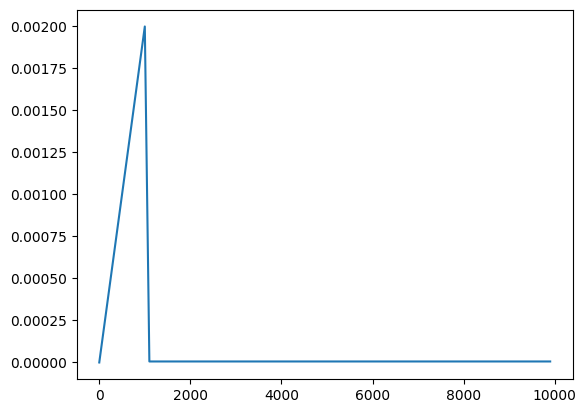

In [ ]:
def test_lr():
    import random
    import matplotlib.pyplot as plt
    x = [i for i in range(0,10000,100)]
    y = [get_lr(i) for i in x]
    plt.plot(x, y)
    plt.show()

test_lr()


In [ ]:
'''
@torch.no_grad()
def estimate_losses(config):
    model.eval()
    losses = {'train': -1., 'val': -1.}
    for split in ['train', 'val']:
        loss = 0
        for _ in range(config.eval_iters):
            # xb, yb = next(iter(val_loader))
            # xb, yb = xb.to(device), yb.to(device)
            xb, yb = get_batch('val')
            loss += model(xb, yb)[1].item()
        loss /= config.eval_iters
        if split == 'train':
            losses['train'] = loss
        else:
            losses['val'] = loss
    model.train()
    return losses
    '''

"\n@torch.no_grad()\ndef estimate_losses(config):\n    model.eval()\n    losses = {'train': -1., 'val': -1.}\n    for split in ['train', 'val']:\n        loss = 0\n        for _ in range(config.eval_iters):\n            # xb, yb = next(iter(val_loader))\n            # xb, yb = xb.to(device), yb.to(device)\n            xb, yb = get_batch('val')\n            loss += model(xb, yb)[1].item()\n        loss /= config.eval_iters\n        if split == 'train':\n            losses['train'] = loss\n        else:\n            losses['val'] = loss\n    model.train()\n    return losses\n    "

In [ ]:
@torch.no_grad()
def estimate_losses(config, train_loader, val_loader):
    model.eval()
    losses = {'train': -1., 'val': -1.}
    train_loss = 0
    train_iters = min(config.eval_iters, len(train_loader))
    for i, (xb, yb) in enumerate(train_loader):
        if i >= train_iters:
            break
        xb, yb = xb.to(device), yb.to(device)
        _, loss = model(xb, yb)
        train_loss += loss.item()
    losses['train'] = train_loss / train_iters

    # Evaluate validation loss (considering only config.eval_iters iterations)
    val_loss = 0
    val_iters = min(config.eval_iters, len(val_loader))
    for i, (xb, yb) in enumerate(val_loader):
        if i >= val_iters:
            break
        xb, yb = xb.to(device), yb.to(device)
        _, loss = model(xb, yb)
        val_loss += loss.item()
    losses['val'] = val_loss / val_iters

    model.train()
    return losses

In [ ]:
#@title Load Pretrained
CKPT_PATH = 'best_model.pth'
ckpt = torch.load(CKPT_PATH)
model.load_state_dict(ckpt)

<All keys matched successfully>

## WandB

In [ ]:
wandb.login(key="11c390c26f231132a3244dc3831234fad032e629")
run = wandb.init(
        name    = 'pretrain_v1', ## Wandb creates random run names if you skip this field
        reinit = True, ### Allows reinitalizing runs when you re-run this cell
        # entity = 'thunderbuddies',
        # run_id = ### Insert specific run id here if you want to resume a previous run
        # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
        project = "ideal_gpt", ### Project should be created in your wandb account
        config = config, ### Wandb Config for your run,
    )

wandb: Currently logged in as: huayuyan (huayuyang). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
start_ix.shape

torch.Size([1, 1])

In [ ]:
cur_iter = 0
best_val = 1e9
best_path = 'best_fine_tune_model.pth'
running_loss = 0.0
loss_counter=0
pbar = tqdm(total=config.num_iters, dynamic_ncols=True, leave=False, position=0, desc="Train")

Train:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
'''
while cur_iter <= config.num_iters:
    optimizer.zero_grad(set_to_none = True) # https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html
    # poor man's lr scheduler
    cur_lr = get_lr(cur_iter) if config.lr_decay else config.lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = cur_lr

    # xb, yb = next(iter(train_loader))
    for micro_step in range(config.gradient_accumulation_steps):
        xb, yb = get_batch('train')
        # xb, yb = xb.to(device), yb.to(device)
        with torch.cuda.amp.autocast():
            logits, loss = model(xb, yb)

        running_loss += loss.item()
        train_loss = running_loss / (loss_counter + 1)
        loss_counter += 1

        scaler.scale(loss).backward()

    if config.grad_clip != 0.0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
    scaler.step(optimizer)
    scaler.update()

    # val every eval_intervals
    if cur_iter % config.eval_interval == 0:
        losses = estimate_losses(config)
        val_loss = losses['val']
        train_loss = losses['train']
        print(f'Val @ Epoch {cur_iter}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}')
        wandb.log({
            'val_loss': val_loss,
            'iter': cur_iter,
            'lr': optimizer.param_groups[0]['lr']
        })
        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), best_path)
            print(f'Saved best model to {best_path}')
        print('Sample Generation')
        print(tokenizer.decode(model.generate(start_ix, 100)[0].tolist()))

    # train logs
    wandb.log({
        'train_loss': train_loss,
        'iter': cur_iter,
        'lr': cur_lr
    })
    pbar.set_postfix(
            loss = "{:.04f}".format(train_loss),
            lr = cur_lr
        )
    pbar.update()


    cur_iter += 1
    '''

'\nwhile cur_iter <= config.num_iters:\n    optimizer.zero_grad(set_to_none = True) # https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html\n    # poor man\'s lr scheduler\n    cur_lr = get_lr(cur_iter) if config.lr_decay else config.lr\n    for param_group in optimizer.param_groups:\n        param_group[\'lr\'] = cur_lr\n\n    # xb, yb = next(iter(train_loader))\n    for micro_step in range(config.gradient_accumulation_steps):\n        xb, yb = get_batch(\'train\')\n        # xb, yb = xb.to(device), yb.to(device)\n        with torch.cuda.amp.autocast():\n            logits, loss = model(xb, yb)\n\n        running_loss += loss.item()\n        train_loss = running_loss / (loss_counter + 1)\n        loss_counter += 1\n\n        scaler.scale(loss).backward()\n\n    if config.grad_clip != 0.0:\n        scaler.unscale_(optimizer)\n        torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)\n    scaler.step(optimizer)\n    scaler.update()\n\n    # va

In [ ]:
torch.cuda.empty_cache()
gc.collect()


cur_iter=0

while cur_iter <= config.num_iters:
    optimizer.zero_grad(set_to_none=True)

    cur_lr = get_lr(cur_iter) if config.lr_decay else config.lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = cur_lr

    # Iterate over batches from the DataLoader
    steps = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        with torch.cuda.amp.autocast():
            logits, loss = model(xb, yb)
        running_loss += loss.item()
        train_loss = running_loss / (loss_counter + 1)
        loss_counter += 1

        scaler.scale(loss).backward()

        steps += 1
        if steps % config.gradient_accumulation_steps == 0:
            if config.grad_clip != 0.0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

        del xb, yb, logits, loss
        torch.cuda.empty_cache()


    losses = estimate_losses(config, train_loader, val_loader)  # Now we pass val_loader to estimate_losses
    val_loss = losses['val']
    train_loss = losses['train']
    print(f'Val @ Epoch {cur_iter}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}')
    wandb.log({
        'val_loss': val_loss,
        'iter': cur_iter,
        'lr': optimizer.param_groups[0]['lr']
    })
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), best_path)
        print(f'Saved best model to {best_path}')
    print('Sample Generation')
    print(tokenizer.decode(model.generate(start_ix, 100)[0].tolist()))

    # Log training metrics for current iteration
    pbar.set_postfix(loss="{:.04f}".format(train_loss), lr=cur_lr)
    pbar.update()

    cur_iter += 1  # Increment iteration count

Val @ Epoch 0: Train Loss=3.9672, Val Loss=3.8640
Saved best model to best_fine_tune_model.pth
Sample Generation


Train:  20%|██        | 1/5 [3:46:15<15:05:02, 13575.58s/it, loss=3.9672, lr=0]

! This book set a record as being female, harder to sell to girls and more important, oh, we fucking hate her.<|endoftext|>[Update; 4/17: Fort Lauderdale is a town you’ll hear all day, counting! This one isn’t in the early 1960s, according to notepads!)

Updated: Dec. 17, 25, Blog: “At the opening of the museum Poelty went to the Showbox. That’s upstairs
Val @ Epoch 1: Train Loss=2.7668, Val Loss=2.7833
Saved best model to best_fine_tune_model.pth
Sample Generation


Train:  40%|████      | 2/5 [7:35:30<11:24:03, 13681.33s/it, loss=2.7668, lr=2e-6]

! acruero Monaco finale diorgio: janitorial du Laert Anthem no victoria by néln, ne pas mênci dada est seventh premiere. L'utilisateur diorgio, diorita dal vale 2.4 dentson a dorter operat diorui des decizationes enver satisfizziter. L'utilisateur a parcheface al partir l'al est militari glane, therefore fulf
Val @ Epoch 2: Train Loss=2.7081, Val Loss=2.6940
Saved best model to best_fine_tune_model.pth
Sample Generation


Train:  60%|██████    | 3/5 [11:24:52<7:37:15, 13717.99s/it, loss=2.7081, lr=4e-6] 

!|<|endoftext|>All photos credit Jessica Sook. She still has a few bouts of anger, ruined by binge drinking. Now, she in fact is extremely relieved to be able to drink enough for her two teenage sons. Liz being an A and C filleteries in Nottingham. Abby, 58, has committed suicide whilst quaking in bed one last time. Parts of a scale from the top to top include Lord Ringo’s £60 bars, which are currently on sale for £30 each
Val @ Epoch 3: Train Loss=2.6816, Val Loss=2.6426
Saved best model to best_fine_tune_model.pth
Sample Generation


Train:  80%|████████  | 4/5 [15:14:15<3:48:55, 13735.64s/it, loss=2.6816, lr=6e-6]

!|system|>
<|endoftext|>Renowned New York-based radio station The Letter America was broadcast on November 21, 1994. The new program was launched on November 22 triumphing eleven episodes and sharing two episodes with Uncertain, Much Odd Couples, TLC, and Spin. In 2010 after one of them aired, Paramount Television released the Do Good Network mini-claunch from its broadcast channels. All of its programming was licensed to CBS in October 2011, as was the Do Good Network/
Val @ Epoch 4: Train Loss=2.5018, Val Loss=2.6105
Saved best model to best_fine_tune_model.pth
Sample Generation


Train: 100%|██████████| 5/5 [19:03:59<00:00, 13753.26s/it, loss=2.5018, lr=8e-6]  

!|system|>
<|endoftext|>Humanity has age, has mass volunteerism, has bipartisanship and guild membership. Participation in any one age group is understood to be a one-way thing, for example, a role not only in American politics as it is included in American politics in many democratic systems today, but has, until recently, primarily been manifested in large-scale resistance protests due to cultural representations. It is a complete thing. With its powerful stripperry it is crucial that
Val @ Epoch 5: Train Loss=2.6285, Val Loss=2.5855
Saved best model to best_fine_tune_model.pth
Sample Generation


Train: 6it [22:53:17, 13754.78s/it, loss=2.6285, lr=1e-5]                       

!|system|>
<|endoftext|>Carlos Vazro search<|endoftext|>An ancient ancient history corresponds to the wide, continuous "Perl 2", a volcanic million dollar fine or greater (Pleife derpaitedus maeres e di filio lumate di crystallise, naΰˈlito, boodle, a branch) known as the Perl II. The rock is well marked with footstone, teeth, topped and tailpans, a large scalarm, and


In [ ]:
print(tokenizer.decode(model.generate(start_ix, 100)[0].tolist()))

!|system|>
<|endoftext|>Another highly unusual part of a physique is that you need to guess that the body's characteristics are not the same as the body will. The more than one ton might be less wasted, the stronger the structure in your abdomen. The bones in the fascinator dry up significantly. For once, the pelvic bones, unlike the pelvic bones, are and still are relatively bland with soft material between them. So the Ebay2001 said that new limbs like me must be dissected


In [ ]:
def generate_text(m, prompt, max_seq=100):
    prompt = prompt.strip()

    chat_template = f"<|user|>\n{' '.join(prompt.split()[:150])}<|endoftext|>\n<|assistant|>"
    prompt_tokens = tokenizer.encode(chat_template, return_tensors='pt').to(device)

    generated_tokens = m.generate(prompt_tokens, max_seq)

    generated_text = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)

    return generated_text[generated_text.find("<|assistant|>") + len("<|assistant|>"):]

In [ ]:
#@title Load Evaluate Models

base_model = Transformer(config).to(device)
base_model.load_state_dict(torch.load('best_model.pth'))

fine_tuned_model = Transformer(config).to(device)
fine_tuned_model.load_state_dict(torch.load('best_fine_tune_model.pth'))

tmp = '''
(CNN)Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thought I was going to help this one person who I don't know, but the fact that so many people can have a life extension, that's pretty big," Broussard told CNN affiliate KGO. She may feel guided in her generosity by a higher power. "Thanks for all the support and prayers," a comment on a Facebook page in her name read. "I know this entire journey is much bigger than all of us. I also know I'm just the messenger." CNN cannot verify the authenticity of the page. But the power that multiplied Broussard's gift was data processing of genetic profiles from donor-recipient pairs. It works on a simple swapping principle but takes it to a much higher level, according to California Pacific Medical Center in San Francisco. So high, that it is taking five surgeons, a covey of physician assistants, nurses and anesthesiologists, and more than 40 support staff to perform surgeries on 12 people. They are extracting six kidneys from donors and implanting them into six recipients. "The ages of the donors and recipients range from 26 to 70 and include three parent and child pairs, one sibling pair and one brother and sister-in-law pair," the medical center said in a statement. The chain of surgeries is to be wrapped up Friday. In late March, the medical center is planning to hold a reception for all 12 patients. Here's how the super swap works, according to California Pacific Medical Center. Say, your brother needs a kidney to save his life, or at least get off of dialysis, and you're willing to give him one of yours. But then it turns out that your kidney is not a match for him, and it's certain his body would reject it. Your brother can then get on a years-long waiting list for a kidney coming from an organ donor who died. Maybe that will work out -- or not, and time could run out for him. Alternatively, you and your brother could look for another recipient-living donor couple like yourselves -- say, two more siblings, where the donor's kidney isn't suited for his sister, the recipient. But maybe your kidney is a match for his sister, and his kidney is a match for your brother. So, you'd do a swap. That's called a paired donation. It's a bit of a surgical square dance, where four people cross over partners temporarily and everybody goes home smiling. But instead of a square dance, Broussard's generous move set off a chain reaction, like dominoes falling. Her kidney, which was removed Thursday, went to a recipient, who was paired with a donor. That donor's kidney went to the next recipient, who was also paired with a donor, and so on. On Friday, the last donor will give a kidney to someone who has been biding time on one of those deceased donor lists to complete the chain. Such long-chain transplanting is rare. It's been done before, California Pacific Medical Center said in a statement, but matching up the people in the chain has been laborious and taken a long time. That changed when a computer programmer named David Jacobs received a kidney transplant. He had been waiting on a deceased donor list, when a live donor came along -- someone nice enough to give away a kidney to a stranger. Jacobs paid it forward with his programming skills, creating MatchGrid, a program that genetically matches up donor pairs or chains quickly. "When we did a five-way swap a few years ago, which was one of the largest, it took about three to four months. We did this in about three weeks," Jacobs said. But this chain wouldn't have worked so quickly without Broussard's generosity -- or may not have worked at all. "The significance of the altruistic donor is that it opens up possibilities for pairing compatible donors and recipients," said Dr. Steven Katznelson. "Where there had been only three or four options, with the inclusion of the altruistic donor, we had 140 options to consider for matching donors and recipients." And that's divine, Broussard's friend Shirley Williams wrote in a comment her on Broussard's Facebook page. "You are a true angel my friend."
'''

print(generate_text(base_model, f'Summarize the following CNN article:\n {tmp}', 50))
print(generate_text(fine_tuned_model, f'Summarize the following CNN article:\n {tmp}', 50))

The Master is a 3D cardboard with removable batteries with an intriguing 3D geometry.

Library Background black cells with brown salt in glass that are highly malleable on black paper.

Skin colour. Honestly, I made these for several

Zully Broussard received kidney for converting Patients' Choice kidney dialysis.
She donated thousands in $2,000 sum to the hospital, charities.
Broussard's transformation spurred donations and swarms of


In [ ]:
#@title Evaluate Summarization

def generate_outputs(classifier):
  references = []
  base_model_outputs = []
  fine_tuned_outputs = []

  count = 0
  for i, row in enumerate(val_dataset):
    if (row['Classifier'] != classifier):
      continue

    output_len = len(tokenizer.encode(row['Target']))
    base_model_output = generate_text(base_model, row['Prompt'], output_len)
    fine_tuned_model_output = generate_text(fine_tuned_model, row['Prompt'], output_len)

    base_model_outputs.append(base_model_output)
    fine_tuned_outputs.append(fine_tuned_model_output)
    references.append([row['Target']])

    # print(output_len)
    # print()
    # print("-------")
    # print("Question:")
    # print(row["Prompt"])
    # print("---Target----")
    # print(row["Target"])
    # print("---PreTrained----")
    # print(base_model_output)
    # print("---FineTune----")
    # print(fine_tuned_model_output)
    # print("-------")
    # print()

    # base_model_bleu_score += sentence_bleu(row['Target'].split(), base_model_output.split())
    # fine_tuned_bleu_score += sentence_bleu(row['Target'].split(), fine_tuned_model_output.split())

    progress_bar.update()

    count = count + 1
    if count >= 1000:
      break

  return references, base_model_outputs, fine_tuned_outputs

val_dataset = load_dataset("ccss4/hw5-finetuning", split = 'validation')

bleu = evaluate.load("bleu")
progress_bar = tqdm(total=13368, dynamic_ncols=True, leave=False, position=0, desc='BLEU')
refs, base_outputs, fine_tuned_outputs = generate_outputs('Summarization')
progress_bar.close()

print("BLEU score for pretrained model: \n", bleu.compute(predictions=base_outputs, references=refs))
print("BLEU score for fine tuned model: \n", bleu.compute(predictions=fine_tuned_outputs, references=refs))

In [190]:
#@title Evaluate Q&A
rouge = evaluate.load("rouge")
progress_bar = tqdm(total=10570, dynamic_ncols=True, leave=False, position=0, desc='ROUGE')
refs, base_outputs, fine_tuned_outputs = generate_outputs('Question&Answer')
progress_bar.close()


print("ROUGE score for pretrained model: \n", rouge.compute(predictions=base_outputs, references=refs))
print("ROUGE score for fine tuned model: \n", rouge.compute(predictions=fine_tuned_outputs, references=refs))

ROUGE score for pretrained model: 
 {'rouge1': 0.005884171647359108, 'rouge2': 0.0001719298245614035, 'rougeL': 0.005884673656145294, 'rougeLsum': 0.005785726595892363}
ROUGE score for fine tuned model: 
 {'rouge1': 0.05058140485230121, 'rouge2': 0.015982299459023463, 'rougeL': 0.05056974137260489, 'rougeLsum': 0.050600098589418996}


In [168]:
run.finish()

iter,▁▂▄▅▇█
lr,▁▂▄▅▇█
val_loss,█▂▂▁▁▁
iter,5
lr,1e-05
val_loss,2.58552
